# Variables Affecting Terry Stops
- Module 3 Project 
- https://github.com/charlottebasch/Variables-Affecting-Terry-Stops

# Introduction

&nbsp; &nbsp; &nbsp; This project uses Seattle Police Department's <a href="https://catalog.data.gov/dataset/terry-stops" target="_blank">Terry Stop data</a> from 2015-2020. Terry Stops, also known as stop and frisk, were allowed by the Supreme Court case Terry v. Ohio in 1968. This case allows police officers to stop and detain an individual they reasonably suspect of having committed, currently committing, or about to commit a crime. In this interaction, they are allowed to pat down, aka frisk, the stopped party. Terry stops are stops that are not based on probable cause, but during the stop probable cause can be found and lead to an arrest. It is worth noting that this practice has been challenged, both by individuals and in court cases, for being disproportionately targeted towards Black and Latinx individuals. However, for as long as the court's decision is upheld, it must be ensured that these stops and arrests are being conducted in an as fair and unbiased way as possible.

&nbsp; &nbsp; &nbsp; The goal of this project was to predict whether a Terry stop lead to an arrest based on variables about the officer, subject, and the content of the stop. Logistic regression, decision trees, and random forest models were tried and compared to generate the best balanced of correctly identifying arrests and non-arrests. While precision and f1 scores were low for all models, the random forest and logistic regression models performed well on AUC and recall. Despite the higher recall score for arrest in the logistic regression, the slightly higher accuracy of the model and better precision and f1 scores for arrests designated the random forest as the best performing model.  

## Background Information:

- https://www.law.cornell.edu/wex/terry_stop/stop_and_frisk

## Data Source:
- https://catalog.data.gov/dataset/terry-stops

# Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
pd.set_option("display.max_rows", 500, "display.max_columns", None)

In [2]:
data = pd.read_csv("Terry_Stops.csv")
display(data.head())

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,-,-,2015-04-01T00:00:00,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44050 entries, 0 to 44049
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         44050 non-null  object
 1   Subject ID                44050 non-null  int64 
 2   GO / SC Num               44050 non-null  int64 
 3   Terry Stop ID             44050 non-null  int64 
 4   Stop Resolution           44050 non-null  object
 5   Weapon Type               44050 non-null  object
 6   Officer ID                44050 non-null  object
 7   Officer YOB               44050 non-null  int64 
 8   Officer Gender            44050 non-null  object
 9   Officer Race              44050 non-null  object
 10  Subject Perceived Race    44050 non-null  object
 11  Subject Perceived Gender  44050 non-null  object
 12  Reported Date             44050 non-null  object
 13  Reported Time             44050 non-null  object
 14  Initial Call Type     

None

- Many of these columns are data that was important to filling the report (i.e. General Offense or Street Check number or the various ID columns). Therefore these columns can be dropped. 
- In addition, the officer squad, precinct, sector, and beat of the officer do not necessarily necessarily correspond to where the Terry stop actually happened. In order to get more general results about location, only precinct, the most general category, is kept.  
- Stop resolution and arrest flag both indicate whether an arrest was made. However stop resolution includes both custodial and non-custodial arrests, which indicates whether a person is physically taken into custody or not. Since the goal of this problem is to simply classify whether or not an arrest occurs, one of these columns must be dropped in order to avoid giving the model information it would not otherwise have. 
    - In this particular case, we will drop the stop resolution and only focus on physical arrests. However it might be important to revisit this problem using the categories of stop resolution instead of just physical arrests. 
- Lastly, the final call type is determined after the Terry Stop and subsequent arrest or non-arrest has already occurred. Therefore it is not an appropriate predictor.  
    - https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [4]:
data = data.drop(columns=["Subject ID", "GO / SC Num", "Terry Stop ID", "Officer ID", "Sector", 
                          "Beat", "Officer Squad", "Stop Resolution", "Final Call Type"])

In [5]:
data.head()

,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Call Type,Arrest Flag,Frisk Flag,Precinct
0,-,None,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,N,N,South
1,-,None,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,-,-,N,N,-
2,-,None,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,-,-,N,-,-
3,-,None,1963,M,White,-,-,2015-04-01T00:00:00,04:55:00,-,-,N,N,-
4,-,None,1977,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,-,-,N,N,-


## Dealing with Missing, Unlikely, or Unclear Values

### Changing and Creating Columns

#### Officer Age and Reported Time

- It would likely be more useful to have an officer's age instead of their year of birth.
- It also does not necessarily serve us to have such specific information about every stop's time and date. The year and time of day should be sufficient. 

In [6]:
data["Reported Date"] = pd.DatetimeIndex(data["Reported Date"]).year
data["Officer Age"] = data["Reported Date"] - data["Officer YOB"]
data = data.drop(columns=["Reported Date", "Officer YOB"])
data["Reported Time"] = data["Reported Time"].map(lambda x: "Day" if int(x.split(":")[0]) < 12 else "Night")
data.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Initial Call Type,Call Type,Arrest Flag,Frisk Flag,Precinct,Officer Age
0,-,None,M,Black or African American,Asian,Male,Day,-,-,N,N,South,31
1,-,None,M,White,-,-,Day,-,-,N,N,-,50
2,-,None,M,White,White,Male,Night,-,-,N,-,-,54
3,-,None,M,White,-,-,Day,-,-,N,N,-,52
4,-,None,M,White,Black or African American,Male,Day,-,-,N,N,-,38


In [7]:
#Look at the most common values for each column to see if there are any strange values
for col in data.columns:
    
    val_counts = data[col].value_counts()
    index_list = []
    value_list = []
    print(f"Number of unique {col} values: {data[col].nunique()}")
    
    #get a list of the values and their counts
    for index, value in val_counts.items():
        index_list.append(index)
        value_list.append(value)
        
    #Create a dataframe of the top 10 values for ease of examination 
    df = pd.DataFrame({col: index_list, "count": value_list})
    display(df.head(10))

Number of unique Subject Age Group values: 7


,Subject Age Group,count
0,26 - 35,14619
1,36 - 45,9275
2,18 - 25,8945
3,46 - 55,5658
4,56 and Above,2230
5,1 - 17,1926
6,-,1397


Number of unique Weapon Type values: 21


,Weapon Type,count
0,None,32565
1,-,8941
2,Lethal Cutting Instrument,1482
3,Knife/Cutting/Stabbing Instrument,461
4,Handgun,274
5,Firearm Other,100
6,Blunt Object/Striking Implement,61
7,"Club, Blackjack, Brass Knuckles",49
8,Firearm,31
9,Mace/Pepper Spray,17


Number of unique Officer Gender values: 3


,Officer Gender,count
0,M,39065
1,F,4974
2,N,11


Number of unique Officer Race values: 9


,Officer Race,count
0,White,33788
1,Hispanic or Latino,2495
2,Two or More Races,2325
3,Asian,1807
4,Black or African American,1757
5,Not Specified,1105
6,Nat Hawaiian/Oth Pac Islander,436
7,American Indian/Alaska Native,311
8,Unknown,26


Number of unique Subject Perceived Race values: 10


,Subject Perceived Race,count
0,White,21543
1,Black or African American,13139
2,Unknown,2297
3,-,1702
4,Hispanic,1684
5,Asian,1396
6,American Indian or Alaska Native,1289
7,Multi-Racial,809
8,Other,152
9,Native Hawaiian or Other Pacific Islander,39


Number of unique Subject Perceived Gender values: 6


,Subject Perceived Gender,count
0,Male,34422
1,Female,9021
2,Unable to Determine,326
3,-,263
4,Unknown,14
5,Gender Diverse (gender non-conforming and/or t...,4


Number of unique Reported Time values: 2


,Reported Time,count
0,Night,23745
1,Day,20305


Number of unique Initial Call Type values: 164


,Initial Call Type,count
0,-,12850
1,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,2846
2,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",2765
3,"DISTURBANCE, MISCELLANEOUS/OTHER",2272
4,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),1861
5,TRESPASS,1742
6,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),1313
7,SHOPLIFT - THEFT,1208
8,FIGHT - IP - PHYSICAL (NO WEAPONS),1205
9,"WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)",1080


Number of unique Call Type values: 8


,Call Type,count
0,911,19523
1,-,12850
2,ONVIEW,8308
3,"TELEPHONE OTHER, NOT 911",3075
4,ALARM CALL (NOT POLICE ALARM),285
5,TEXT MESSAGE,6
6,PROACTIVE (OFFICER INITIATED),2
7,SCHEDULED EVENT (RECURRING),1


Number of unique Arrest Flag values: 2


,Arrest Flag,count
0,N,41615
1,Y,2435


Number of unique Frisk Flag values: 3


,Frisk Flag,count
0,N,33826
1,Y,9746
2,-,478


Number of unique Precinct values: 10


,Precinct,count
0,West,10253
1,North,9722
2,-,9687
3,East,5839
4,South,5246
5,Southwest,2320
6,SouthWest,740
7,Unknown,200
8,OOJ,28
9,FK ERROR,15


Number of unique Officer Age values: 56


,Officer Age,count
0,31,2974
1,30,2766
2,33,2677
3,32,2622
4,29,2436
5,34,2385
6,28,2335
7,26,2079
8,27,2058
9,35,1791


In [8]:
#Clearly "-" is not a valid value so we can replace it with nan to distingiush it so it can be addressed
data = data.replace("-", np.nan)

def find_percent_null(df):
    """Calculates the percentage null values in each column and prints them."""
    
    null_nums = df.isnull().sum()
    total_rows = df.shape[0]
    
    for index, value in null_nums.items():
        percent_missing = round((value/total_rows)*100, 2)
        print(f"{percent_missing}% of {index} values are missing.")

find_percent_null(data)

3.17% of Subject Age Group values are missing.
20.3% of Weapon Type values are missing.
0.0% of Officer Gender values are missing.
0.0% of Officer Race values are missing.
3.86% of Subject Perceived Race values are missing.
0.6% of Subject Perceived Gender values are missing.
0.0% of Reported Time values are missing.
29.17% of Initial Call Type values are missing.
29.17% of Call Type values are missing.
0.0% of Arrest Flag values are missing.
1.09% of Frisk Flag values are missing.
21.99% of Precinct values are missing.
0.0% of Officer Age values are missing.


Clearly there is a much greater prevalence of missing values for subjects compared to officers. 

### Combining and Renaming Values

#### Call Type/Method

- On View refers to an officer witnessing an incident. In order to keep dimensions more concise, proactive can be combined into this category. In addition, the two other least common categories can be combined into an other category. 
    - https://www.phoenix.gov/policesite/Documents/Police%20Terminology%20for%20Website.pdf
- In addition the name of this column is slightly misleading, implying that it is the same as the initial call type, when it is really the call method. Therefore this is the new name for the column.

In [9]:
#These are the current values for call type
list(data["Call Type"].unique())

[nan,
 '911',
 'ONVIEW',
 'TELEPHONE OTHER, NOT 911',
 'ALARM CALL (NOT POLICE ALARM)',
 'TEXT MESSAGE',
 'PROACTIVE (OFFICER INITIATED)',
 'SCHEDULED EVENT (RECURRING)']

In [10]:
data["Call Type"] = data["Call Type"].replace({"ONVIEW": "Officer Initiated", 
                                               "TELEPHONE OTHER, NOT 911": "Telephone, Not 911", 
                                               "ALARM CALL (NOT POLICE ALARM)": "Non-Police Alarm",
                                               "PROACTIVE (OFFICER INITIATED)": "Officer Initiated",
                                               "TEXT MESSAGE": "Other",
                                               "SCHEDULED EVENT (RECURRING)": "Other"})
data = data.rename(columns={"Call Type": "Call Method"})

In [11]:
#These are the new values for call type
list(data["Call Method"].unique())

[nan,
 '911',
 'Officer Initiated',
 'Telephone, Not 911',
 'Non-Police Alarm',
 'Other']

#### Race and Gender

- There are some discrepancies in category names between officer and subject racial categories. In order to look at the relationship between officer and subject race, these discrepancies must be eliminated. 
    - One potential point of concern is that subject race is being perceived. Therefore categories such as "unknown" "multi-racial" could be referring to people with a great range of skin colors and racial identities. The fact that these categories are not more specific could have multiple causes or meanings.    
- Similarly, there are also discrepancies between officer and subject gender. 
    - As with race, there are problems with officers perceiving gender. While the gender diverse category is very small, there may be subjects who are listed as male or female who are miscategorized. 

In [12]:
#These are the current values for officer and subject race
list(data["Officer Race"].unique()), list(data["Subject Perceived Race"].unique())

(['Black or African American',
  'White',
  'Hispanic or Latino',
  'Asian',
  'American Indian/Alaska Native',
  'Two or More Races',
  'Nat Hawaiian/Oth Pac Islander',
  'Not Specified',
  'Unknown'],
 ['Asian',
  nan,
  'White',
  'Black or African American',
  'Other',
  'Unknown',
  'American Indian or Alaska Native',
  'Hispanic',
  'Multi-Racial',
  'Native Hawaiian or Other Pacific Islander'])

In [13]:
#These are the current values for officer and subject gender
list(data["Officer Gender"].unique()), list(data["Subject Perceived Gender"].unique())

(['M', 'F', 'N'],
 ['Male',
  nan,
  'Female',
  'Unable to Determine',
  'Unknown',
  'Gender Diverse (gender non-conforming and/or transgender)'])

In [14]:
#Replace the differing terms for officer and subject race
officer_race_dict = {"Not Specified": "Unknown", 
                     "Two or More Races": "Multi-Racial",
                     "Nat Hawaiian/Oth Pac Islander": "Native Hawaiian or Other Pacific Islander",
                     "American Indian/Alaska Native": "American Indian or Alaska Native"}

data["Officer Race"] = data["Officer Race"].replace(officer_race_dict)

data["Subject Perceived Race"] = data["Subject Perceived Race"].replace({"Hispanic": "Hispanic or Latino", 
                                                                         "Other": "Unknown"})

#Replace the differing terms for officer and subject gender
subject_gender_dict = {"Gender Diverse (gender non-conforming and/or transgender)": "Gender Diverse",
                       "Unable to Determine": "Unknown"}

data["Subject Perceived Gender"] = data["Subject Perceived Gender"].replace(subject_gender_dict)

#The N values for officer gender have some other potentially unreasonable values so for now only 
#male and female labels are transformed
data["Officer Gender"] = data["Officer Gender"].replace({"M": "Male", "F": "Female"})

In [15]:
#These are the new values for officer and subject race
list(data["Officer Race"].unique()), list(data["Subject Perceived Race"].unique())

(['Black or African American',
  'White',
  'Hispanic or Latino',
  'Asian',
  'American Indian or Alaska Native',
  'Multi-Racial',
  'Native Hawaiian or Other Pacific Islander',
  'Unknown'],
 ['Asian',
  nan,
  'White',
  'Black or African American',
  'Unknown',
  'American Indian or Alaska Native',
  'Hispanic or Latino',
  'Multi-Racial',
  'Native Hawaiian or Other Pacific Islander'])

In [16]:
#These are the new values for officer and subject gender
list(data["Officer Gender"].unique()), list(data["Subject Perceived Gender"].unique())

(['Male', 'Female', 'N'], ['Male', nan, 'Female', 'Unknown', 'Gender Diverse'])

#### Age

- In order to improve the model, we can change the age ranges into numeric averages. It is probably rare for someone under the age of 10 or over the age of 65 to be stopped in a Terry Stop, so those values were chosen as bounds for the under 17 and over 56 categories respectively. 
- Since less than 5% of age values are missing, we can drop those rows.

In [17]:
#Create a list of the age ranges in this dataset
age_values = data["Subject Age Group"].value_counts()
ages_list = list(age_values.index)
print(ages_list)

['26 - 35', '36 - 45', '18 - 25', '46 - 55', '56 and Above', '1 - 17']


In [18]:
ages_map = {}

for age in ages_list:
    
    try: 
        ages = age.split(" ")
        lower = int(ages[0])
        upper = int(ages[2])
        #we do not want to take the true average of 1-17 because it would skew too young so we've chosen to consider
        #10 as the lower bound
        if lower == 1:
            lower = 10
            ages_map[age] = (lower + upper)/2
        else:
            ages_map[age] = (lower + upper)/2
            
    #since "56 and above" contains a word, we cannot take the average so we've assigned it 65
    except ValueError:
        ages_map[age] = 65

#replace the age ranges with the averages and drop null values
data["Subject Age Group"] = data["Subject Age Group"].map(ages_map)
data = data.dropna(subset=["Subject Age Group"])

In [19]:
#These are the new values for subject age group
list(data["Subject Age Group"].unique())

[13.5, 21.5, 30.5, 40.5, 50.5, 65.0]

In [20]:
#Next we examine officer age, noting that the maximum is quite strange and age should be investigated further
display(data["Officer Age"].describe())

#Look at the percentages of data for older age groups to see where the problem begins
for age in [53, 60, 70]:
    percent = len(data[data["Officer Age"] > age])/len(data["Officer Age"]) * 100
    print(f"The data indicate that {round(percent,2)}% of officers in the dataset are over {age}.")

count    42653.000000
mean        34.674396
std          8.686564
min         21.000000
25%         29.000000
50%         33.000000
75%         39.000000
max        120.000000
Name: Officer Age, dtype: float64

The data indicate that 3.96% of officers in the dataset are over 53.
The data indicate that 0.38% of officers in the dataset are over 60.
The data indicate that 0.06% of officers in the dataset are over 70.


In [21]:
#Check the value counts of ages over 53
print("Age values over 53")
display(data[data["Officer Age"] > 53]["Officer Age"].value_counts())
#Clearly there are multiple values between 53 and 70 before a huge gap to impossible ages

#Eliminate all of the incorrect data
data = data[data["Officer Age"] < 100]

Age values over 53


54     429
55     313
56     244
57     215
58     164
59      88
60      73
61      39
63      29
62      18
65      16
120     15
64      14
67      11
119      4
68       4
118      3
66       2
116      2
69       1
70       1
115      1
117      1
Name: Officer Age, dtype: int64

- In examining the officer ages and noting the ages over 53, it has become clear that some data must have entered incorrectly. The rows containing these ages can be dropped since it is a small percentage of data. 
- Police officers in Washington State, where this data was collected, are eligible to retire at age 53. While there is a small percentage of data where the officer is listed as being between 53 and 70, those age are still reasonable enough that they can be left in the dataset. In addition, there are no ages between 70 and 115, indicating that the ages 70 and under are real.

#### Precinct

- The Seattle police are divided into <a href="https://www.seattle.gov/police/about-us/about-policing/precinct-and-patrol-boundaries#:~:text=Seattle%20is%20divided%20into%20five,geographic%20and%20other%20natural%20boundaries" target="_blank">five</a> precincts: North, East, West, South, and Southwest. The two different capitalizations of southwest need to be combined and the other categories can be coalesced into one unknown category. 

In [22]:
#These are the current values for precinct
list(data["Precinct"].unique())

[nan,
 'East',
 'North',
 'West',
 'South',
 'Southwest',
 'Unknown',
 'SouthWest',
 'FK ERROR',
 'OOJ']

In [23]:
predict_dict = {"SouthWest": "Southwest", "OOJ": "Unknown", "FK ERROR": "Unknown"}
data["Precinct"] = data["Precinct"].replace(predict_dict)

In [24]:
#These are the new values for precinct
list(data["Precinct"].unique())

[nan, 'East', 'North', 'West', 'South', 'Southwest', 'Unknown']

In [25]:
#Looking at weapons we can see that not having a weapon is most common 
#with the value missing being the second most common
data["Weapon Type"].value_counts(normalize=True, dropna=False)

None                                 0.741173
NaN                                  0.200554
Lethal Cutting Instrument            0.034157
Knife/Cutting/Stabbing Instrument    0.010627
Handgun                              0.006123
Firearm Other                        0.002182
Blunt Object/Striking Implement      0.001384
Club, Blackjack, Brass Knuckles      0.001126
Firearm                              0.000727
Mace/Pepper Spray                    0.000399
Firearm (unk type)                   0.000352
Other Firearm                        0.000328
Club                                 0.000211
Rifle                                0.000141
None/Not Applicable                  0.000141
Taser/Stun Gun                       0.000141
Shotgun                              0.000070
Fire/Incendiary Device               0.000070
Automatic Handgun                    0.000047
Blackjack                            0.000023
Brass Knuckles                       0.000023
Name: Weapon Type, dtype: float64

The weapons can be combined into different categories based on their use. 

In [26]:
#Based on the words in the weapon description, we can sort them into types
weapons = data["Weapon Type"].value_counts()
weapons_list = list(weapons.index)
weapons_map = {}

for weapon in weapons_list:
    
    if "None" in weapon:
        weapons_map[weapon] = "None"
    
    #Different types of guns occur semi-frequently in this dataset so any words indicating a gun can 
    #go into this category
    elif "Handgun" in weapon or "Firearm" in weapon or "Rifle" in weapon or "Shotgun" in weapon:
        weapons_map[weapon] = "Firearm"
    
    #There were also a fair number of cutting or stabbing instruments so these words can become a category as well
    elif "Cutting" in weapon or "Stabbing" in weapon:
        weapons_map[weapon] = "Stabbing/Cutting Instrument"
    
    #These types of weapons were quite rare and do not fit into any category easily so we can combine them
    #into an other
    elif "Mace/Pepper Spray" in weapon or "Taser/Stun Gun" in weapon or "Fire/Incendiary Device" in weapon:
        weapons_map[weapon] = "Other"
    
    #The rest of the weapons can be used to strike someone so they can become a category
    else:
        weapons_map[weapon] = "Striking Implement"

#Replace the existing weapon type values with the new values
data["Weapon Type"] = data["Weapon Type"].map(weapons_map)

In [27]:
#These are the new values for weapons
list(data["Weapon Type"].unique())

['None',
 'Firearm',
 'Stabbing/Cutting Instrument',
 nan,
 'Other',
 'Striking Implement']

#### Initial Call Type

In [28]:
print("Initial Call Type")
display(data["Initial Call Type"].value_counts(normalize=True, dropna=False))

Initial Call Type


NaN                                                   0.290684
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW            0.065170
SUSPICIOUS PERSON, VEHICLE OR INCIDENT                0.063059
DISTURBANCE, MISCELLANEOUS/OTHER                      0.051540
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)        0.042063
TRESPASS                                              0.039787
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)             0.029934
SHOPLIFT - THEFT                                      0.027635
FIGHT - IP - PHYSICAL (NO WEAPONS)                    0.027307
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)        0.024538
ROBBERY - IP/JO (INCLUDES STRONG ARM)                 0.019096
BURG - IP/JO - RES (INCL UNOCC STRUCTURES)            0.015788
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)         0.015014
NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)      0.015014
DIST - IP/JO - DV DIST - NO ASLT                      0.014826
PROPERTY - DAMAGE                                     0

- Clearly the last problem with the Terry Stops data is the large amount of categories for initial call type. They have been split into more general categories to maximize the usefulness of the model. 
- Because not all of the initial call types (i.e. "suspicious person" correspond to crimes, we cannot simply look at Seattle's crime classifications and use those to group the initial call types. 
- Therefore the grouping choices have to be more holistic and based on commonalities. We can try and distinguish different types of call types, making sure each category has a similar level of severity and danger. 
- To do this, different words were identified that were similar to other words and categories were formed. Going through the list, each call type was placed into an existing category or a new one was created.  

In [29]:
i_call_types = data["Initial Call Type"].value_counts()
i_call_list = list(i_call_types.index)
i_call_map = {}

for item in i_call_list:
    
    #These are expected events where the outcome of an arrest or non-arrest is anticipated going in
    if (("FOLLOW UP" in item or "ORDER" in item or "WARRANT" in item) and
        "NO WELFARE CHK OR DV ORDER SERVICE" not in item and "NO COURT ORDR" not in item):
        i_call_map[item] = "Follow-Up/Warrant"
        
    elif "SFD" in item or "AGENCY" in item or "ASSIST SPD" in item:
        i_call_map[item] = "Assist SPD or Other Agency"
        
    #No explicit crime is being reported 
    elif ("SUSPICIOUS" in item or "PROWLER" in item or "OPEN" in item) and ("INCL OPEN LINE" not in item and
          "INCLUDES OPEN LINE" not in item):
        i_call_map[item] = "Suspicion of Crime"
        
    elif ((
        "THEFT" in item or "ROBBERY" in item or "BURG" in item or "TRESPASS" in item or "PROPERTY" in item or
         "AUTO RECOVERY" in item or "ALARM" in item or "FRAUD" in item
    ) and  "THEFT OF SERVICES" not in item and "FOUND GUN" not in item):
            i_call_map[item] = "Property Crime"
            
    elif ("WEAPN" in item or "SHOTS" in item or "GUN" in item) and "NO WEAPONS" not in item:
        i_call_map[item] = "Weapon"
        
    elif (("ASLT" in item or "PHYSICAL" in item or "FIGHT" in item) and 
          "NO ASLT" not in item and "NO THRT" not in item):
        i_call_map[item] = "Assault/Fight"
        
    #This category refers to crimes where no explicit danger to people or property is being posed 
    elif ((
     "DISTURBANCE" in item or "DIST" in item or "NARCOTICS" in item or "NUISANCE" in item or
     "LIQUOR VIOLATIONS" in item or "PROSTITUTION" in item or "PANHANDLING" in item or
     "PEDESTRIAN VIOLATIONS" in item or "ILLEGAL DUMPING" in item or "NOISE" in item or 
     "PARKS VIOLATIONS/CITES" in item or "SLEEPER" in item or "LITTERING" in item or
    "GAMBLING" in item) and "DV" not in item and "OBSCENE" not in item):
        i_call_map[item] = "Minor Offenses"    
        
    elif (("THREATS" in item or "LEWD" in item or "SEX" in item or "HARAS" in item or "BIAS" in item or
          "OBSCENE" in item) and "BOMB" not in item):
            i_call_map[item] = "Threats/Harassment"
                  
    elif (("CRISIS" in item or "SUICIDE" in item or "WELFARE" in item or "SICK PERSON" in item or 
           "INJURED" in item or "BITE" in item or "OVERDOSE" in item) and  
           ("NO WELFARE CHK OR DV ORDER SERVICE" not in item and 
           "NO COURT ORDR" not in item and "ANIMAL - INJURED" not in item)):
            i_call_map[item] = "Mental or Physical Health"
            
    elif "DUI" in item or "MVC" in item or "TRAFFIC" in item or "PARKING" in item:
        i_call_map[item] = "Motor Vehicle"
        
    elif "AWOL" in item or "MISSING" in item or "KIDNAPPNG" in item:
        i_call_map[item] = "Missing Person"
        
    elif "CHILD" in item or "JUVENILE" in item:
        i_call_map[item] = "Child Welfare" 
        
    else:
        i_call_map[item] = "Other"
        
#Replace the initial call type values      
data["Initial Call Type"] = data["Initial Call Type"].map(i_call_map)
list(data["Initial Call Type"].unique())

[nan,
 'Weapon',
 'Assault/Fight',
 'Other',
 'Assist SPD or Other Agency',
 'Property Crime',
 'Threats/Harassment',
 'Suspicion of Crime',
 'Minor Offenses',
 'Follow-Up/Warrant',
 'Motor Vehicle',
 'Mental or Physical Health',
 'Child Welfare',
 'Missing Person']

### Adding Officer-Subject Comparison Columns

In [30]:
print("Officer Race")
display(data["Officer Race"].value_counts(normalize=True, dropna=False)) 
print("Subject Perceived Race")
display(data["Subject Perceived Race"].value_counts(normalize=True, dropna=False))

Officer Race


White                                        0.770122
Hispanic or Latino                           0.055927
Multi-Racial                                 0.053088
Asian                                        0.040397
Black or African American                    0.038215
Unknown                                      0.025336
Native Hawaiian or Other Pacific Islander    0.009783
American Indian or Alaska Native             0.007132
Name: Officer Race, dtype: float64

Subject Perceived Race


White                                        0.496610
Black or African American                    0.300608
Unknown                                      0.051751
Hispanic or Latino                           0.038896
Asian                                        0.032045
NaN                                          0.030685
American Indian or Alaska Native             0.029746
Multi-Racial                                 0.018791
Native Hawaiian or Other Pacific Islander    0.000868
Name: Subject Perceived Race, dtype: float64

- Clearly there is a discrepancy between officer and subject race so it might be useful to create comparison data.
- It is also worth noting that according to the <a href="https://www.seattle.gov/opcd/population-and-demographics/about-seattle#raceethnicity" target="_blank">2014-2018</a> American Community Survey (ACS) 5-Year Estimates (U.S. Census Bureau) Seattle has the following demographic makeup:
    - White - 64.5% (+/- 0.4 percentage pts.)
    - Black or African American - 6.8% (+/- 0.3 percentage pts.)
    - American Indian & Alaska Native - 0.5% (+/- 0.1 percentage pts.)
    - Asian - 14.9% (+/- 0.4 percentage pts.)
    - Native Hawaiian & Other Pacific Islander - 0.3% (+/- 0.1 percentage pts.)
    - Other race - 0.3% (+/- 0.1 percentage pts.)
    - Two or more races - 6.0% (+/- 0.2 percentage pts.)
    - Hispanic or Latino ethnicity (of any race): 6.6% (+/- 0.3 percentage pts.)
- White individuals are very overrepresented as officers and underrepresented as subjects of Terry Stops.
- Asian individuals are underrepresented as both officers and subjects. 
- Black or African American individuals are underrepresented as officers and very overrepresented as subjects of Terry Stops.
- For other races, there are not significant differences. 

In [31]:
#Get a race comparison for each row of data 
officer_races = list(data["Officer Race"])
subject_races = list(data["Subject Perceived Race"])
race_comparisons = list(zip(officer_races, subject_races))
race_vals = []

for comparison in race_comparisons:
    if "Unknown" in comparison:
            race_vals.append("Unknown")
    else:
        if comparison[0] == comparison[1]:
            race_vals.append("Same")
        else: 
            race_vals.append("Different")
            
data["Race Comparisons"] = race_vals
list(data["Race Comparisons"].unique())

['Same', 'Different', 'Unknown']

In [32]:
print("Officer Gender")
display(data["Officer Gender"].value_counts(normalize=True, dropna=False)) 
print("Subject Perceived Gender")
display(data["Subject Perceived Gender"].value_counts(normalize=True, dropna=False))

Officer Gender


Male      0.886363
Female    0.113637
Name: Officer Gender, dtype: float64

Subject Perceived Gender


Male              0.789992
Female            0.206841
Unknown           0.002698
NaN               0.000375
Gender Diverse    0.000094
Name: Subject Perceived Gender, dtype: float64

- There is a much smaller discrepancy in gender for officers and subjects, but it is worth including a comparison. 

In [33]:
#Get a gender comparison for each row of data 
officer_genders = list(data["Officer Gender"])
subject_genders = list(data["Subject Perceived Gender"])
gender_comparisons = list(zip(officer_genders, subject_genders))
gender_vals = []

for comparison in gender_comparisons:
    if "Unknown" in comparison:
            gender_vals.append("Unknown")
    else:
        if comparison[0] == comparison[1]:
                gender_vals.append("Same")
        else:
            gender_vals.append("Different")
            
data["Gender Comparisons"] = gender_vals
list(data["Gender Comparisons"].unique())

['Different', 'Same', 'Unknown']

In [34]:
data.head()

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Initial Call Type,Call Method,Arrest Flag,Frisk Flag,Precinct,Officer Age,Race Comparisons,Gender Comparisons
1119,13.5,None,Male,White,White,Female,Day,NaN,NaN,N,N,NaN,37,Same,Different
1147,13.5,None,Male,White,Black or African American,Male,Day,NaN,NaN,N,N,NaN,37,Different,Same
1175,13.5,None,Male,White,White,Male,Day,NaN,NaN,N,N,NaN,37,Same,Same
1400,13.5,None,Male,White,American Indian or Alaska Native,Male,Day,NaN,NaN,N,Y,East,23,Different,Same
1401,13.5,None,Female,Unknown,Unknown,Male,Day,NaN,NaN,N,Y,NaN,27,Unknown,Different


# Visualizations

In [35]:
#Seperate the predictor columns into numerical and categorical
X = data.drop(columns="Arrest Flag").copy()
cat_cols = X.select_dtypes("O").columns
num_cols = X.select_dtypes("number").columns

In [36]:
def create_catplots(cols, nrows, ncols, rotation=25, figsize=(10, 15), hue=None):
    """Create a catplot based on a list of columns."""
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, col in enumerate(cols): 
        if ncols == 1:
            sns.countplot(x=col,data=data, hue=hue, ax=axes[i])
            axes[i].set_title(f"{col} Count")
        else:
            sns.countplot(x=col, data=data, hue=hue, ax=axes[i//ncols, i%ncols])
            axes[i//ncols, i%ncols].set_title(f"{col} Count")
            
    #In order to see the category values on the x-axis better, we rotate the labels      
    #from https://stackoverflow.com/questions/19273040/rotating-axis-text-for-each-subplot
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=rotation, ha="right")    
    plt.tight_layout()

### Race

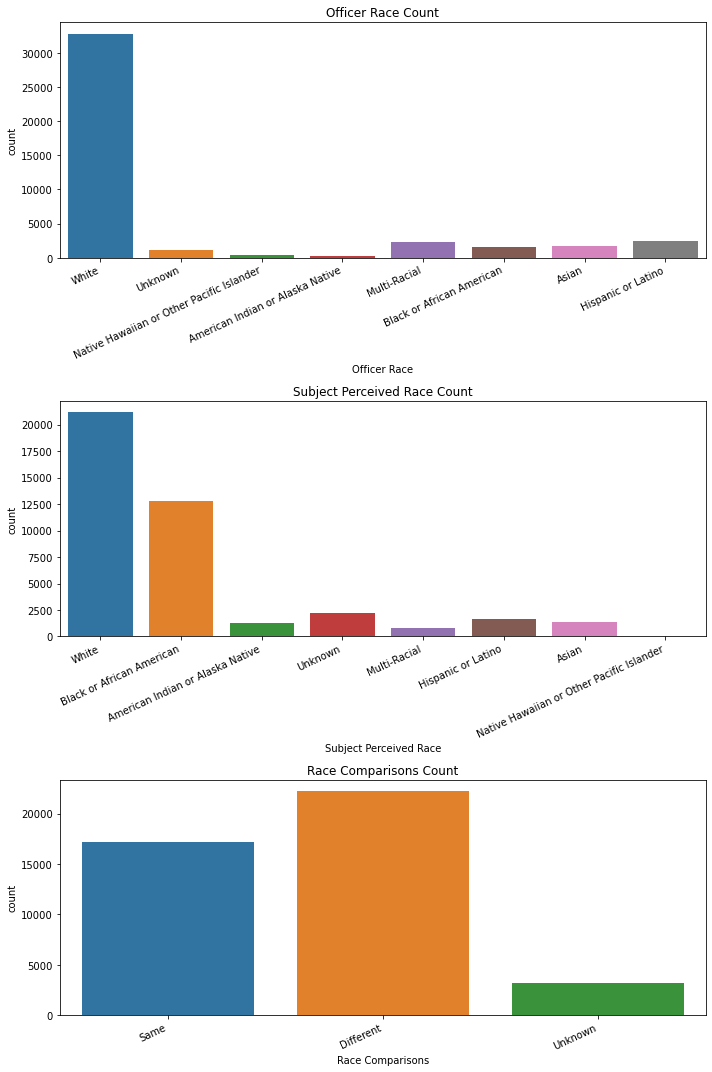

In [37]:
race_cols = ["Officer Race", "Subject Perceived Race", "Race Comparisons"]
create_catplots(race_cols, 3, 1)

- Clearly there is a discrepancy between officer race and subject perceived race, with the majority of interactions occurring between those of different races.

### Gender

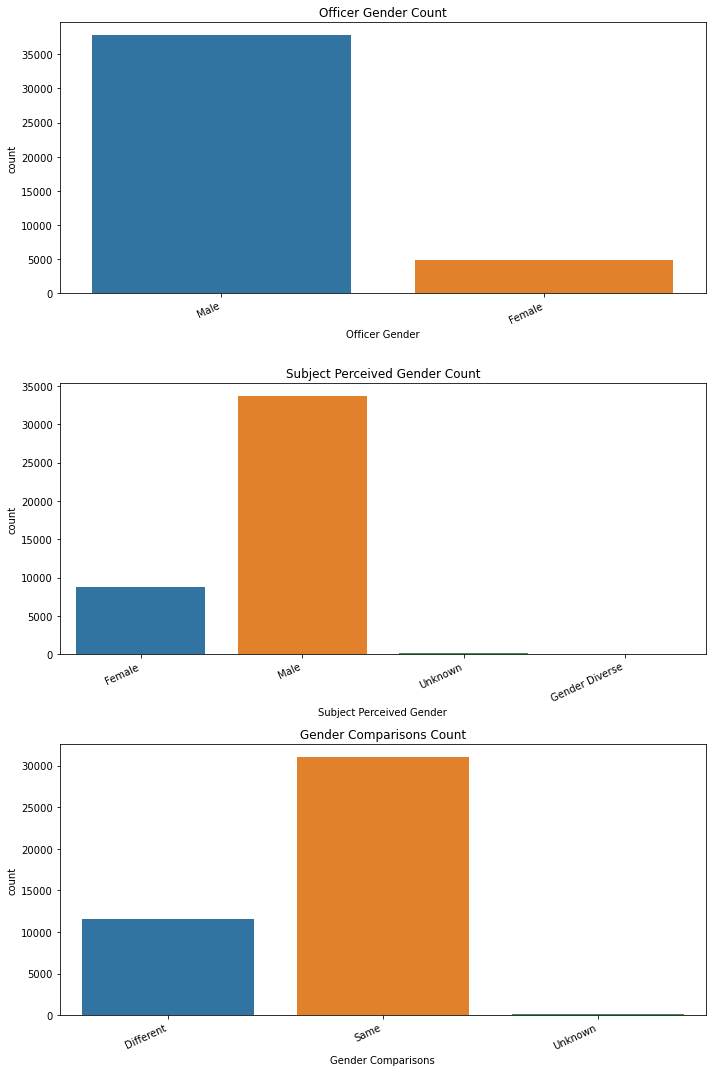

In [38]:
gender_cols = ["Officer Gender", "Subject Perceived Gender", "Gender Comparisons"]
create_catplots(gender_cols, 3, 1)

- Most stops are occurring between those of the same gender.

### Remaining Categorical Variables

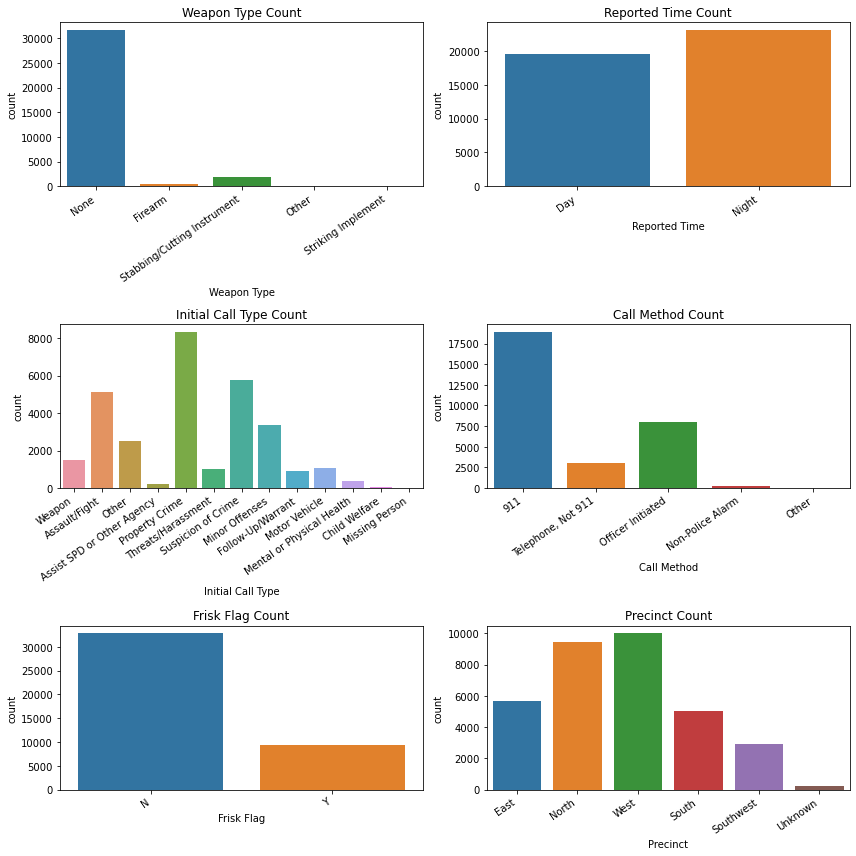

In [39]:
remaining_cats = ["Weapon Type", "Reported Time", "Initial Call Type", "Call Method", "Frisk Flag", "Precinct"]
create_catplots(remaining_cats, 3, 2, 35, (12, 12))

### Age

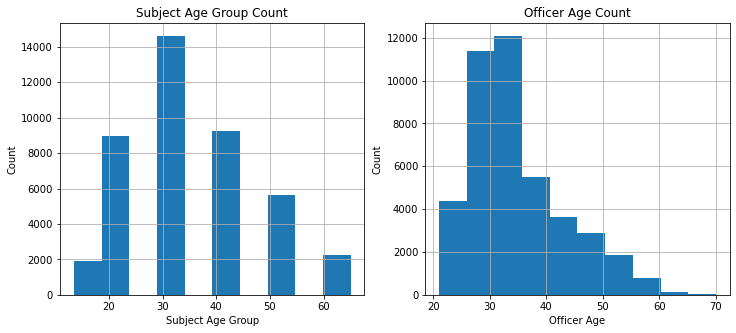

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, col in enumerate(num_cols):
    data[col].hist(ax=axes[i])
    axes[i].set(title=f"{col} Count", xlabel=col, ylabel="Count")

# Preparing Data for Analysis

In [41]:
#In order to perform analyses, the target column must be a number
data["Arrest Flag"] = data["Arrest Flag"].map({"N": 0, "Y": 1})

In [42]:
#Designate the y values, since we have already created X, and set up a test-train split
y = data["Arrest Flag"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Transforming Columns

- The categorical columns still have missing labels, so those must be filled in.
- By noting the values that are missing, we will see if the fact that they had not been provided is relevant. 
- In addition the categorical columns must be encoded before analysis. 

In [43]:
cat_transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("Encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))])
cat_transformer

Pipeline(steps=[('Imputer',
                 SimpleImputer(fill_value='Missing', strategy='constant')),
                ('Encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

- For numeric columns, must transform them so that they are on the same scale and the larger range of age does not erroneously cause the model to interpret them as more important. 

In [44]:
#Since we did observe some high values with officer age, using RobustScaler will decrease the influence of these
#potential outliers
num_transformer = Pipeline(steps=[("Scaler", RobustScaler())])
num_transformer

Pipeline(steps=[('Scaler', RobustScaler())])

In [45]:
#We can combine the preprocessing for the numeric and categorical columns into one and transform the data with them.
preprocessing = ColumnTransformer(transformers=[
    ("Numeric", num_transformer, num_cols),
    ("Categorical", cat_transformer, cat_cols)])
preprocessing

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('Scaler', RobustScaler())]),
                                 Index(['Subject Age Group', 'Officer Age'], dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Time',
       'Initial Call Type', 'Call Method', 'Frisk Flag', 'Precinct',
       'Race Comparisons', 'Gend

In [46]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)

In [47]:
#In order to check that the preprocessing worked, we can retrieve the new column names from the encoder
#and create a dataframe to see clearly that the transformation worked as intended. 
cat_feats = preprocessing.named_transformers_["Categorical"].named_steps["Encoder"].get_feature_names(cat_cols)

X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns=[*num_cols, *cat_feats])
X_test_preprocessed = pd.DataFrame(X_test_preprocessed,columns=[*num_cols, *cat_feats])

X_train_preprocessed.head()

,Subject Age Group,Officer Age,Weapon Type_Firearm,Weapon Type_Missing,Weapon Type_None,Weapon Type_Other,Weapon Type_Stabbing/Cutting Instrument,Weapon Type_Striking Implement,Officer Gender_Female,Officer Gender_Male,Officer Race_American Indian or Alaska Native,Officer Race_Asian,Officer Race_Black or African American,Officer Race_Hispanic or Latino,Officer Race_Multi-Racial,Officer Race_Native Hawaiian or Other Pacific Islander,Officer Race_Unknown,Officer Race_White,Subject Perceived Race_American Indian or Alaska Native,Subject Perceived Race_Asian,Subject Perceived Race_Black or African American,Subject Perceived Race_Hispanic or Latino,Subject Perceived Race_Missing,Subject Perceived Race_Multi-Racial,Subject Perceived Race_Native Hawaiian or Other Pacific Islander,Subject Perceived Race_Unknown,Subject Perceived Race_White,Subject Perceived Gender_Female,Subject Perceived Gender_Gender Diverse,Subject Perceived Gender_Male,Subject Perceived Gender_Missing,Subject Perceived Gender_Unknown,Reported Time_Day,Reported Time_Night,Initial Call Type_Assault/Fight,Initial Call Type_Assist SPD or Other Agency,Initial Call Type_Child Welfare,Initial Call Type_Follow-Up/Warrant,Initial Call Type_Mental or Physical Health,Initial Call Type_Minor Offenses,Initial Call Type_Missing,Initial Call Type_Missing Person,Initial Call Type_Motor Vehicle,Initial Call Type_Other,Initial Call Type_Property Crime,Initial Call Type_Suspicion of Crime,Initial Call Type_Threats/Harassment,Initial Call Type_Weapon,Call Method_911,Call Method_Missing,Call Method_Non-Police Alarm,Call Method_Officer Initiated,Call Method_Other,"Call Method_Telephone, Not 911",Frisk Flag_Missing,Frisk Flag_N,Frisk Flag_Y,Precinct_East,Precinct_Missing,Precinct_North,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Race Comparisons_Different,Race Comparisons_Same,Race Comparisons_Unknown,Gender Comparisons_Different,Gender Comparisons_Same,Gender Comparisons_Unknown
0,0.000000,-0.272727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.894737,-0.636364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.526316,0.727273,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.526316,-0.636364,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.526316,-0.090909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Model Building

In [48]:
#We will be evaluating multiple models so we can view the classification report, confusion matrix, and roc 
#curve easily
def evaluate_classifier(X_train, y_train, X_test, y_test, model, labels):
    """Get the classification report, confusion matrix, and ROC curve for a provided model."""
    
    #Predict values for the test set
    y_hat_test = model.predict(X_test)
    
    #Label and print the classification report
    model_name = str(model).split("(")[0]
    print(f"Classification Report for {model_name} \n") 
    print(metrics.classification_report(y_test, y_hat_test, target_names=labels))
    
    #Plot the confusion matrix and ROC curve
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    metrics.plot_confusion_matrix(model, X_test, y_test, normalize="true", 
                                  display_labels=labels, ax=axes[0], cmap="YlGnBu")
    axes[0].set_title("Confusion Matrix", y=1.05)
    metrics.plot_roc_curve(model, X_test, y_test, ax=axes[1])
    axes[1].plot([0,1],[0,1])
    axes[1].set_title("ROC Curve", y=1.05)
    fig.tight_layout()

## Logistic Regression

- We start with logistic regression because it is the simplest and least computationally expensive model.

Classification Report for LogisticRegression 

              precision    recall  f1-score   support

   No Arrest       1.00      0.83      0.91     10052
      Arrest       0.26      0.95      0.40       605

    accuracy                           0.84     10657
   macro avg       0.63      0.89      0.66     10657
weighted avg       0.95      0.84      0.88     10657



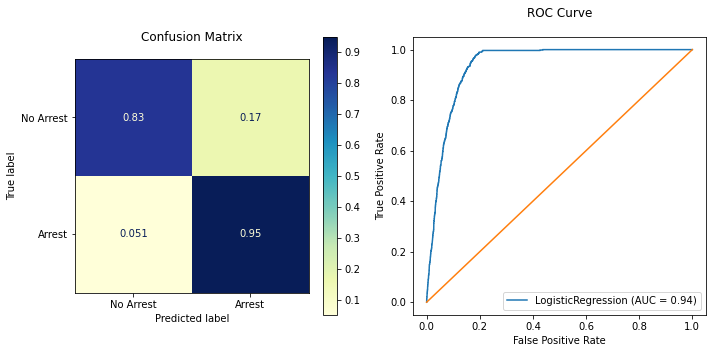

In [49]:
logreg = LogisticRegression(C=1000, random_state=42, solver="newton-cg", class_weight={1:10, 0:1})
logreg.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       logreg, ["No Arrest", "Arrest"])

- This model performed quite well. However the low f1-score and precision for the arrest categorical are not ideal. Therefore we move on to a more complex model. 

## Decision Tree

- Next we move to the decision tree. This is also a less complex model and can be easily visualized. 

Classification Report for DecisionTreeClassifier 

              precision    recall  f1-score   support

   No Arrest       0.96      0.96      0.96     10052
      Arrest       0.36      0.37      0.36       605

    accuracy                           0.93     10657
   macro avg       0.66      0.66      0.66     10657
weighted avg       0.93      0.93      0.93     10657



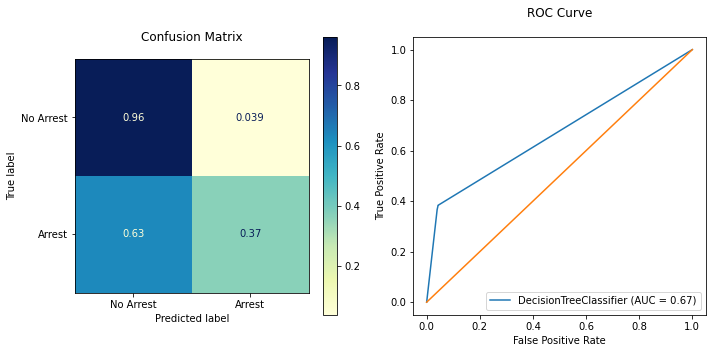

In [50]:
#decision tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       decision_tree, ["No Arrest", "Arrest"])

- Clearly this model is good at classifying the majority class but not the minority class.
- In oder to improve this model multiple grid searches were run, emphasizing f1-score as it represents both precision and recall.

The following grid search (as well as others with greater ranges for the parameters) was run to determine the best parameters for our decision tree: 

` param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10, 15, 20],
              "min_samples_leaf": [1, 5, 10],
              "class_weight": ["balanced", {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]}
gridsearch = GridSearchCV(decision_tree, param_grid=param_grid, cv=5, scoring="f1")`

Classification Report for DecisionTreeClassifier 

              precision    recall  f1-score   support

   No Arrest       0.99      0.88      0.93     10052
      Arrest       0.29      0.81      0.43       605

    accuracy                           0.88     10657
   macro avg       0.64      0.85      0.68     10657
weighted avg       0.95      0.88      0.90     10657



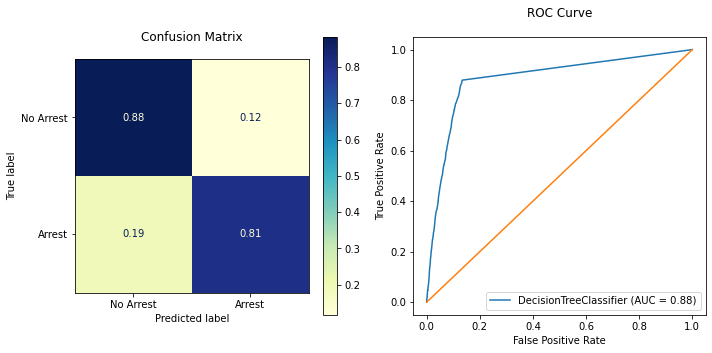

In [51]:
best_dt = DecisionTreeClassifier(random_state=42, class_weight={1: 10, 0: 1}, criterion="gini", 
                                 min_samples_leaf=10, min_samples_split=10)
best_dt.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       best_dt, ["No Arrest", "Arrest"])

- The decision tree was not improved enough to stop here. Since decision trees are prone to overfitting, we can move onto ensemble methods. 

## Random Forest

- Since random forest models are still very interpretable, it is a good next step.

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

   No Arrest       0.95      0.99      0.97     10052
      Arrest       0.44      0.19      0.27       605

    accuracy                           0.94     10657
   macro avg       0.70      0.59      0.62     10657
weighted avg       0.92      0.94      0.93     10657



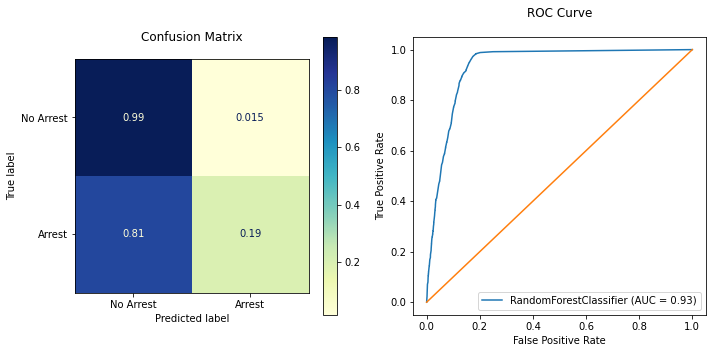

In [52]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       random_forest, ["No Arrest", "Arrest"])

- Much like the decision tree, this model performed poorly when predicting arrests. 
- Again multiple grid searches were run to improve f1-score, with this being the last one:

` param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [5, 10, 15],
              "min_samples_leaf": [5, 10, 20],
              "class_weight": ["balanced", {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]}
gridsearch = GridSearchCV(random_forest, param_grid=param_grid, cv=5, scoring="f1") `

Classification Report for RandomForestClassifier 

              precision    recall  f1-score   support

   No Arrest       0.99      0.89      0.94     10052
      Arrest       0.31      0.84      0.45       605

    accuracy                           0.88     10657
   macro avg       0.65      0.87      0.70     10657
weighted avg       0.95      0.88      0.91     10657



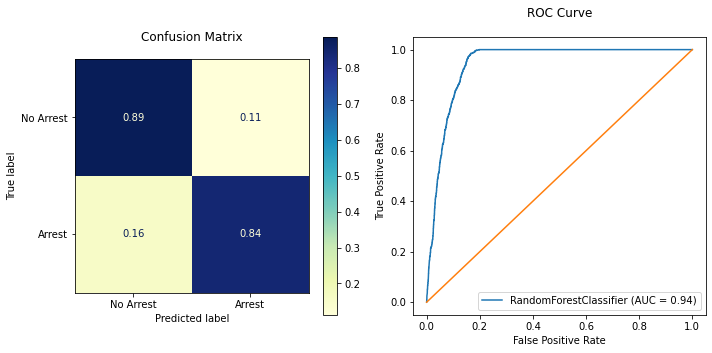

In [53]:
best_rf = RandomForestClassifier(random_state=42, class_weight={1: 10, 0: 1}, criterion="gini", 
                                 min_samples_leaf=5, min_samples_split=5)
best_rf.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       best_rf, ["No Arrest", "Arrest"])

- While the logistic regression had higher recall for arrests, this model has a better balance between recall for arrests and non-arrests. In addition, it has both higher f1-score and precision for arrests.

## Stacking Classifier

- It is possible that these models can be greater than the sum of their parts. Therefore we can try a stacking classifier. 

Classification Report for StackingClassifier 

              precision    recall  f1-score   support

   No Arrest       0.99      0.87      0.93     10052
      Arrest       0.29      0.91      0.44       605

    accuracy                           0.87     10657
   macro avg       0.64      0.89      0.68     10657
weighted avg       0.95      0.87      0.90     10657



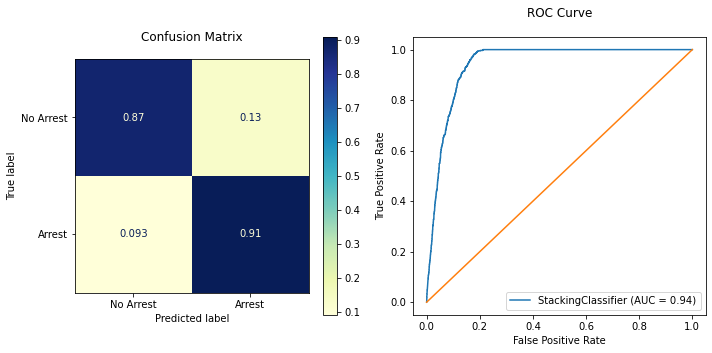

In [54]:
estimators = [("lr", logreg), ("rf", best_rf), ("dt", best_dt)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight={1:10, 0:1}))
clf.fit(X_train_preprocessed, y_train)
evaluate_classifier(X_train_preprocessed, y_train, X_test_preprocessed, y_test, 
                       clf, ["No Arrest", "Arrest"])

- Like the logistic regression, this model does have some strong features but ultimately is not as well rounded as the random forest on its own. 

# Feature Importances

- We will plot the top 25 most important features from the random forest. 

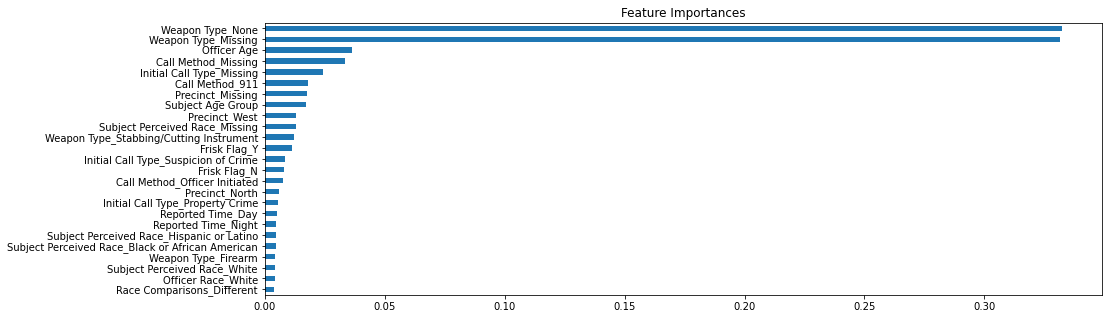

In [55]:
fig, ax = plt.subplots(figsize=(15,5))
importance = pd.Series(best_rf.feature_importances_, index=X_train_preprocessed.columns)
most_important = importance.sort_values().tail(25)
most_important.plot(kind="barh", ax=ax, title="Feature Importances");

In [56]:
top_25 = list(most_important.sort_values(ascending=False).index)

In [57]:
features = list(map(lambda x: x.split("_"), top_25))
feats = []
for i in range(len(features)):
    if features[i][0] not in feats:
        feats.append(features[i][0])

In [59]:
feats

['Weapon Type',
 'Officer Age',
 'Call Method',
 'Initial Call Type',
 'Precinct',
 'Subject Age Group',
 'Subject Perceived Race',
 'Frisk Flag',
 'Reported Time',
 'Officer Race',
 'Race Comparisons']

In [58]:
features

[['Weapon Type', 'None'],
 ['Weapon Type', 'Missing'],
 ['Officer Age'],
 ['Call Method', 'Missing'],
 ['Initial Call Type', 'Missing'],
 ['Call Method', '911'],
 ['Precinct', 'Missing'],
 ['Subject Age Group'],
 ['Precinct', 'West'],
 ['Subject Perceived Race', 'Missing'],
 ['Weapon Type', 'Stabbing/Cutting Instrument'],
 ['Frisk Flag', 'Y'],
 ['Initial Call Type', 'Suspicion of Crime'],
 ['Frisk Flag', 'N'],
 ['Call Method', 'Officer Initiated'],
 ['Precinct', 'North'],
 ['Initial Call Type', 'Property Crime'],
 ['Reported Time', 'Day'],
 ['Reported Time', 'Night'],
 ['Subject Perceived Race', 'Hispanic or Latino'],
 ['Subject Perceived Race', 'Black or African American'],
 ['Weapon Type', 'Firearm'],
 ['Subject Perceived Race', 'White'],
 ['Officer Race', 'White'],
 ['Race Comparisons', 'Different']]

In [192]:
data = data.fillna("Missing")

In [193]:
def feature_catplots(x):
    """List the values of the category specified in feature importance (if categorical) and plots the column."""
    
    #check for categical columns, and print out the important levels of the feature
    if x in cat_cols:
        fig, ax = plt.subplots(figsize=(6,4))
        print(f"Important Aspects of {x} are:")
        for feature in features:
            if x in feature:
                print(f"- {feature[1]}")
                
    #make the plot wider for numeric columns to accomodate the greater number of values
    else:
        fig, ax = plt.subplots(figsize=(12,4))
        
    #plot the counts seperated by arrest
    sns.countplot(x=x, data=data, hue="Arrest Flag");
    plt.xticks(rotation=35, ha="right");
    plt.title(f"{x} Counts by Arrest Flag")
    
def check_percentage(x):
    """Plot the percentage arrested for the specified category."""
    
    df = data.groupby(x)["Arrest Flag"].value_counts(normalize=True).to_frame("Percent Arrests"). reset_index()
    df = df[df["Arrest Flag"] == 1].set_index(x)
    df["Percent Arrests"].plot(kind="bar", title=f"Percent Arrested by {x}")

Important Aspects of Weapon Type are:
- None
- Missing
- Stabbing/Cutting Instrument
- Firearm


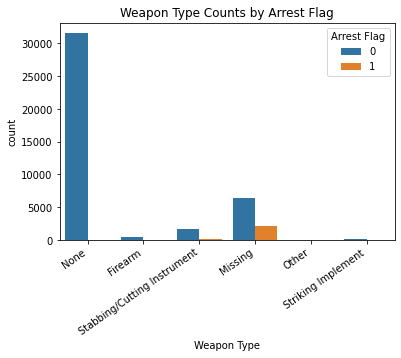

In [194]:
feature_catplots(feats[0])

- It is unclear from the graph how firearms and stabbing instruments compare as far as arrests, so we observe the percentage of arrests by weapon type. 

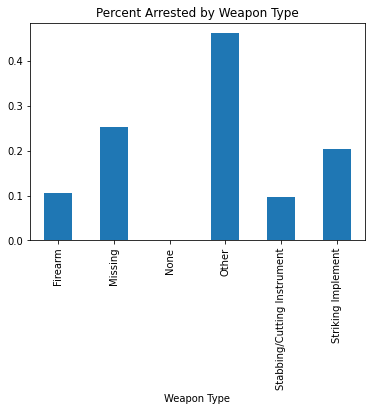

In [195]:
check_percentage(feats[0])

- As would be expected, those who have no weapon are very unlikely to be arrested but have a high rate of stops.
- In addition those who have a firearm or stabbing/cutting instrument are less likely to be arrested.  
- However have the weapon type be missing is related to the largest amount of arrests but a smaller proportion than values not listed in the important features. This is a concern because we cannot infer whether a weapon was related to the arrest/non-arrest or why it is missing. 

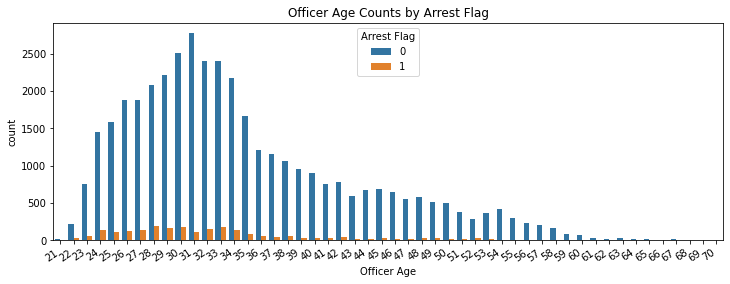

In [196]:
feature_catplots(feats[1])

- Arrests and non-arrests are more common for younger officers. This might be due to younger officers being in a position to make Terry Stops because they have fewer other duties. 

Important Aspects of Call Method are:
- Missing
- 911
- Officer Initiated


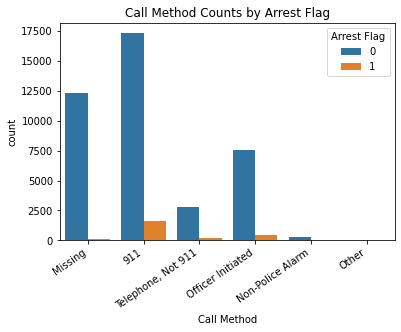

In [197]:
feature_catplots(feats[2])

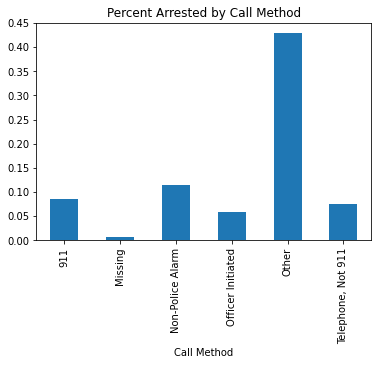

In [198]:
check_percentage(feats[2])

- When a 911 call is made, the most arrests were also made while the second smallest proportion of arrests are made when the officer initiates the stop without another call method.  
- When the call method is missing, arrests are least common. Again because of the lack of information it is hard to speculate why. 
- However there a high rate of stops for missing call methods, second only to 911 calls. Again, this leads to more questions than answers. 

Important Aspects of Initial Call Type are:
- Missing
- Suspicion of Crime
- Property Crime


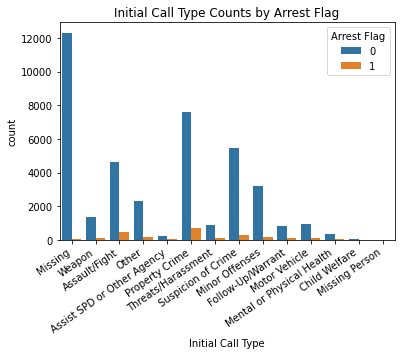

In [199]:
feature_catplots(feats[3])

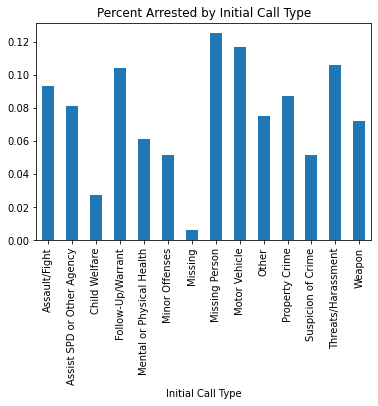

In [200]:
check_percentage(feats[3])

- Arrest are least common when the initial call type is missing. This is likely related to the missing general call methods. Arrests are also less common for suspicions of crime despite their high rate of stops. 
- Most non-missing non-arrests are for the initial call type of property crime.
- These three values have the highest rates of stops, particularly when the initial call type is missing. 

Important Aspects of Precinct are:
- Missing
- West
- North


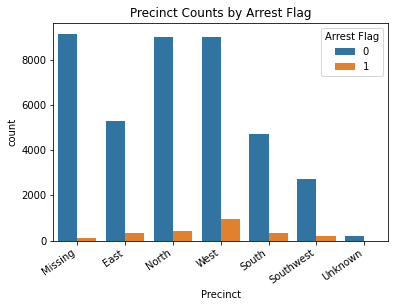

In [201]:
feature_catplots(feats[4])

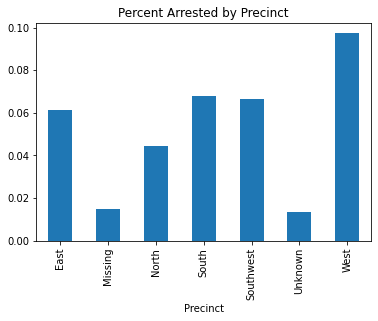

In [202]:
check_percentage(feats[4])

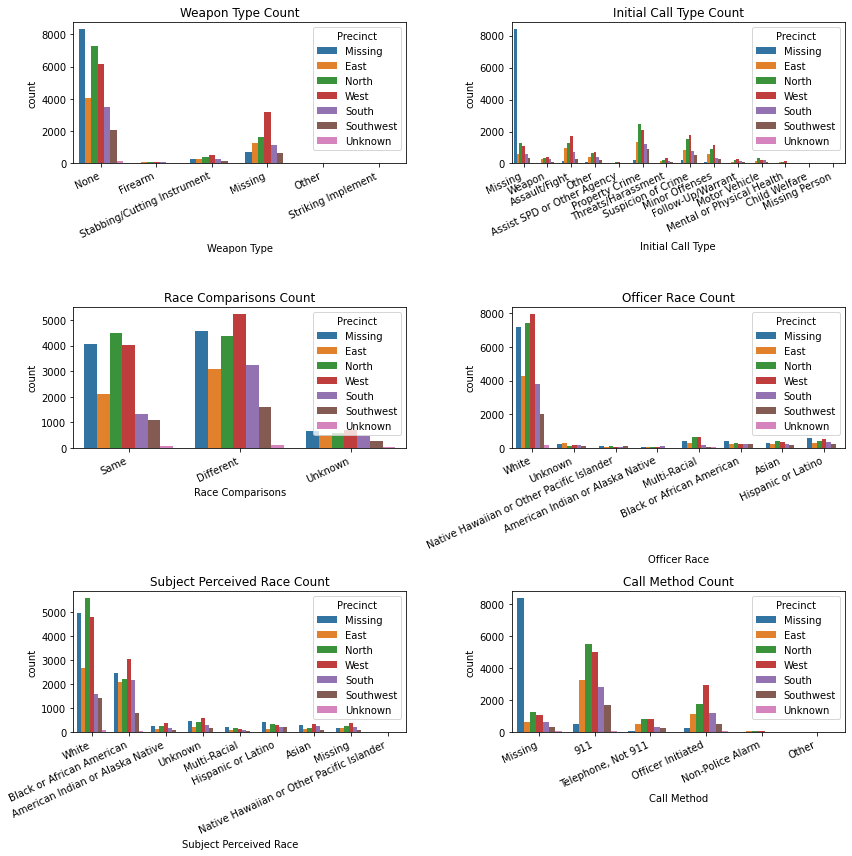

In [203]:
#In order to gain more insight into the importance of precinct, we can plot it compared to other variables
cols = ["Weapon Type", "Initial Call Type", "Race Comparisons", "Officer Race", "Subject Perceived Race", 
        "Call Method"]
create_catplots(cols, 3, 2, rotation=25, figsize=(12, 12), hue="Precinct")

- Having the precinct be missing or having an officer from the North precinct are associated with lower rates of arrest, while being from the West precinct is associated with higher rates of arrest. The <a href="http://www.seattle.gov/police/information-and-data/tweets-by-beat" target="_blank"> West</a> precinct does cover mostly higher economic status and racially homogeneous areas but does contain a small portion of more economically disadvantaged <a href="https://seattlecitygis.maps.arcgis.com/apps/Minimalist/index.html?appid=764b5d8988574644b61e644e9fbe30d1" target="_blank">areas</a>. 
    - As seen above, the West precinct had the largest amount of different race stops, the highest number of White officer stops, the highest number of African American/Black subjects stopped, the highest number of officer initiated stops, and the highest number of missing weapon type data. Further data collection would have to be done to determine if these facts are related but it is something to note. 
    - The North precinct had the highest number of same race stops and White individuals stopped. The North precinct also had the highest number of stops where the initial call type was 911. Again additional data would have to be collected and analyzed to determine if these facts are related.  
    - Having call type and call method missing were related to having precinct missing. 
- These three precincts have the highest stop rates. 

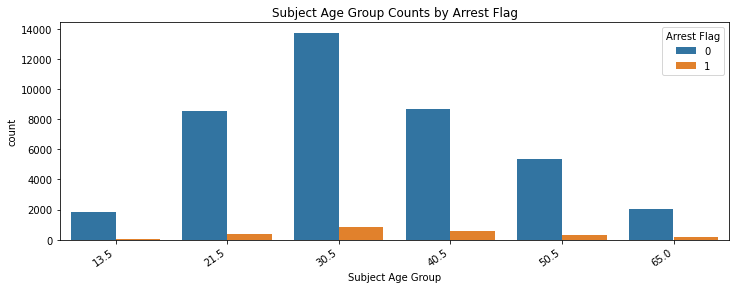

In [72]:
feature_catplots(feats[5])

- Arrests and stops are less common for the youngest and oldest age groups.

Important Aspects of Subject Perceived Race are:
- Missing
- Hispanic or Latino
- Black or African American
- White


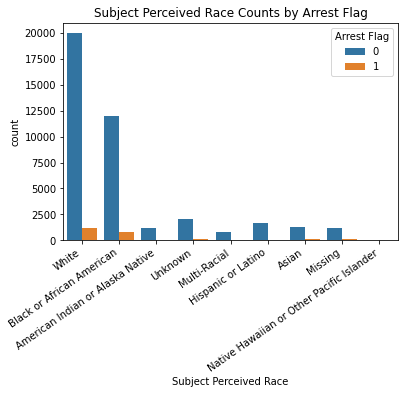

In [73]:
feature_catplots(feats[6])

- Both White and Black/African American individuals are the most arrested and most common non-arrests. There are no arrests of Hispanic or Latino people despite higher stop rates than other groups. The lack of reporting for subject race was also important to the model, once again highlighting the problems with missing data.    

Important Aspects of Frisk Flag are:
- Y
- N


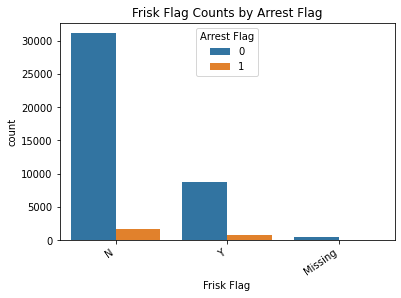

In [75]:
feature_catplots(feats[7])

- Because Missing is the only relatively unimportant part of the frisk flag, it does not provide much useful information. 

Important Aspects of Reported Time are:
- Day
- Night


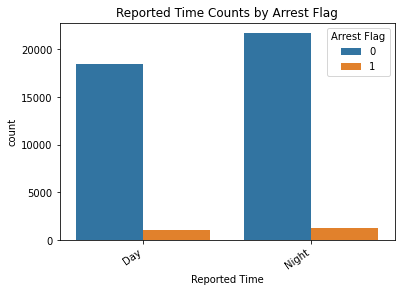

In [76]:
feature_catplots(feats[8])

- Once again both aspects are important so this does not provide much relevant information.

Important Aspects of Officer Race are:
- White


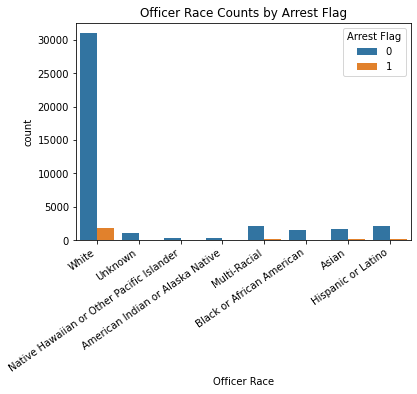

In [77]:
feature_catplots(feats[9])

- White officers make up the bulk of overall stops and arrests so it makes sense that this would be important.

Important Aspects of Race Comparisons are:
- Different


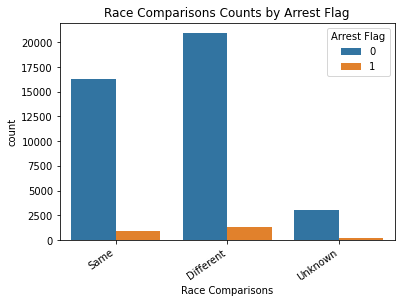

In [78]:
feature_catplots(feats[10])

- Since the majority of stops and arrests were make by officers of a different race than the subject, this also seems to be an important factor. 

# Conclusion

&nbsp; &nbsp; &nbsp; With 88% accuracy, our model is fairly good at predicted whether or not an arrest is made. One of the biggest throughlines of the important features was the impact of missing data. In five of the eleven columns that had a feature in the top 25, the missing category was marked as significant. This means the model was highly influenced by the lack of data. While it is beyond the scope of this project to read into the intent of the lack of reporting, it is a serious issue and more stringent standards for reporting should be enforced to get a clearer picture of what factors are truly important to predicting the outcome of Terry Stops. 

&nbsp; &nbsp; &nbsp; There were some expected findings, such as not having a weapon being related to not being arrested. Some of the findings, like the differences between precincts in stops and arrests, require further information. If more precise data about the actual location was collected, some light could be shed on this category. It is also possible there is some element of the precincts impacted these numbers that was not captured by the collected data. In addition, the importance of both officer and subject age should be investigated further.  

&nbsp; &nbsp; &nbsp; Concerningly, multiple categories concerning race were deemed important in the model. Ideally the most important features of the model would revolve around objective measures such as the presence of a weapon or time of day. Given that stop and frisk has received legal challenges for its disproportionate affect on Black and Latinx individuals, measures should be taken to address differences in stops for racial groups overall and by precinct.  